# Preprocessing

### This notebook is first in the series of soiling detection pipeline notebooks

Data from other parks (eg Park1) can be used by changing the filepaths and working_dir

Author: Lisa Crowther

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import copy
import matplotlib.pyplot as plt
from pathlib import Path

In [14]:
from sys import path as syspath
syspath.insert(1, '../src/')


## Import dataframes from previous notebook


In [15]:
root_path = "../data/raw/New_data/"
park1_power_filepath = root_path + "SolarPark2_Oct_2019_Oct2020_string_production.csv"
park1_environment_filepath = root_path + "Solarpark2_Oct_2019_Oct2020_environmental.csv"
park1_capacity_filepath = root_path + "Solarpark_2_CB_capacity.csv"

In [16]:
working_dir = "../data/temp/park2/"


In [17]:
def read_data(power_data_filepath, env_data_filepath, cap_data_filepath):
    df_pow = pd.read_csv(power_data_filepath, delimiter=';',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
    df_env = pd.read_csv(env_data_filepath, delimiter = ',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
    df_cap = pd.read_csv(cap_data_filepath)
    return [df_pow, df_env, df_cap]


In [18]:
df_pow, df_env, df_cap = read_data(park1_power_filepath, park1_environment_filepath, park1_capacity_filepath)


### Clean dataframes:
Rename columns

In [19]:

df_env.columns = ['Temp_A', 'Temp_P', 'Irradiance']
df_cap.columns= ['displayname', 'capacity_kW', 'number_panels']

In [21]:

Inversors =df_pow.columns[(df_pow.columns).str.contains('Inv')]
RCBs =df_pow.columns[(df_pow.columns).str.contains('RCB')]
strings = df_pow.columns[(df_pow.columns).str.contains('ST')]
CBs=df_pow.columns[(df_pow.columns).str.contains('CB')]

Remove RCB columns (in park 1 contains NAs only)
Remove inversors columns (want to analyse individual strings or CBs)

In [22]:

df_pow.drop(columns=(RCBs), inplace=True)
df_pow.drop(columns=(Inversors), inplace=True)

In [23]:

df_cap.dropna(inplace=True)


### Calculate efficiency of panels

In [24]:
pan_No = df_cap.number_panels
pan_No.index=df_cap.displayname
cap= df_cap.capacity_kW
cap.index=df_cap.displayname


In [25]:

panelArea=1.956*.992
#in m2, from datasheet
totalPanelA= pan_No*panelArea
totalPanelA.dropna(inplace=True)


In [26]:
Efficiency = cap/totalPanelA
Efficiency= round(Efficiency.tail(1).values[0],4)


Merge power and environment dataframes, drop rows where Irradiance is NA

In [27]:
power_env = pd.merge(df_pow,df_env, on=['datetime'], how='inner')


In [28]:

power_env_sub = power_env.dropna(subset=['Irradiance'])

df_env_sub =df_env.dropna(subset=['Irradiance'])

Calculate theoretical outputs (maxP)


In [29]:
# env data without nas 
df_env_sub = df_env_sub.dropna()


In [30]:
# Irradiance and temperature adjustment
To = 25
gamma = -0.004

In [31]:
df_env_sub['irr_T_adj'] = df_env_sub.Irradiance/1000 * (1+((df_env_sub.Temp_P-To) * gamma))
factor_Irr_Temp = df_env_sub.drop(columns=['Temp_A','Temp_P','Irradiance'])


In [32]:
# Panel area and efficiency adjustment
AE = (totalPanelA*Efficiency).dropna()
AE.unique()

array([237.63879014, 227.73717389, 207.93394138, 148.52424384,
       217.83555763, 188.13070886, 138.62262758, 198.03232512,
       128.72101133])

In [33]:

#multiply the area and efficiency for each string by the irradiance and temperature adjustment factor
#this has only dates where irradiance was not NA
for i in range(len(AE)):

    factor_Irr_Temp[AE.index[i]]=factor_Irr_Temp.irr_T_adj*AE[i]
    
#this is the A * E for each string multiplied by the irradiance * temperature adjustment factor : ie power max in Watts

In [34]:
## Theoretical output dataframe: adjusted power output values and drop the adjustment factor column

maxP_df = copy.deepcopy(factor_Irr_Temp.drop(columns=['irr_T_adj']))


In [35]:
# Output dataframe where irradiance is not NA
output_sub= power_env_sub.drop(columns=['Temp_A','Temp_P', 'Irradiance'])
output_sub.head()

,CB 1.01_(kW),CB 1.02_(kW),CB 1.03_(kW),CB 1.04_(kW),CB 1.05_(kW),CB 1.06_(kW),CB 1.07_(kW),CB 1.08_(kW),CB 1.09_(kW),CB 1.10_(kW),...,CB 4.02_(kW),CB 4.03_(kW),CB 4.04_(kW),CB 4.05_(kW),CB 4.06_(kW),CB 4.07_(kW),CB 4.08_(kW),CB 4.09_(kW),CB 4.10_(kW),CB 4.11_(kW)
datetime,,,,,,,,,,,,,,,,,,,,,
2019-10-01 10:35:00,0.000000,0.198920,0.198920,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.797808,0.797808,0.897534,0.199452,0.199452,0.000000,0.199452,0.199452,0.299178,0.219397
2019-10-01 10:40:00,0.099060,0.277368,0.277368,0.079248,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.891450,0.891450,0.970690,0.257530,0.277340,0.099050,0.277340,0.316960,0.376390,0.277340
2019-10-01 10:45:00,0.161117,0.342373,0.342373,0.140977,0.02014,0.0,0.0,0.0,0.040279,0.0,...,0.943929,0.964013,1.004180,0.281170,0.341421,0.140585,0.301254,0.341421,0.421756,0.281170
2019-10-01 10:50:00,0.000000,0.209124,0.209124,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.836096,0.856998,0.940608,0.209024,0.209024,0.000000,0.209024,0.209024,0.271731,0.209024
2019-10-01 10:55:00,0.000000,0.213716,0.213716,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.854032,0.896734,0.960786,0.213508,0.213508,0.000000,0.213508,0.213508,0.277560,0.213508


In [36]:
maxP_df.columns=output_sub.columns

### Calculate Energy Performance Index (EPI)
Power output/ theoretical calculated output

In [38]:
EPI= output_sub.div(maxP_df)

<AxesSubplot:xlabel='datetime'>

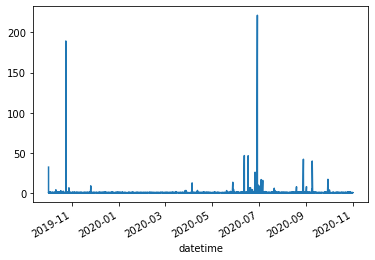

In [39]:
EPI.median(axis=1).plot()

### Save csvs: 
Output data of strings/CBs only, EPIs of strings/CBs, theoretical output of strings/CBs


In [40]:
##save data function from Marcus's scripts
def save_data(dataframes, names, root_dir, sub_dir):

    if root_dir[-1] != "/":
                root_dir += "/"

    if sub_dir[-1] != "/":
                root_dir += sub_dir + "/"

    for data, name in zip(dataframes, names):
        try:
            filepath_out = root_dir + name + ".csv"
            Path(root_dir).mkdir(parents=True, exist_ok=True)
            print(f"\tSaving {filepath_out}...")
            data.to_csv(filepath_out)
            print("\tDone.")
        except Exception as e:
            print(e)
            pass

In [67]:

save_data([output_sub, EPI, maxP_df], ["df_output", "df_EPI", 'df_theor_output'], working_dir, "preprocessing")

	Saving ../data/temp/park2/preprocessing/df_output.csv...
	Done.
	Saving ../data/temp/park2/preprocessing/df_EPI.csv...
	Done.
	Saving ../data/temp/park2/preprocessing/df_theor_output.csv...
	Done.
